# Training the model for Wessels2022

In [1]:
import sys
sys.path.append("../../multicpa")

In [2]:
import torch
from MultiCPA.train import train_compert
from MultiCPA.api import ComPertAPI
from MultiCPA.train import prepare_compert

In [3]:
%load_ext autoreload
%autoreload 2 

### Recommended Method with `seml`

SEML is a experiment management library used in this project: https://github.com/TUM-DAML/seml

The file 'multicpa-reproducibility/seml/seml_config_vol_20.yaml' is the demo seml 'yaml' file to train one model with predefined parameters. All other 'yaml' files in that directory is used during hypermarameter estimation and/or model development. 

You need to create a directory similar to 'multicpa-reproducibility/pretrained_models/seml20' first. 

Then, using the conda environment 'multicpa_env', you need to run the following command on terminal. 

In [27]:
%%bash
pwd

/mnt/home/icb/kemal.inecik/work/codes/multicpa-reproducibility/notebooks


In [29]:
%%bash
seml mpert20 add /home/icb/kemal.inecik/work/codes/multicpa-reproducibility/seml/seml_config_vol_20.yaml start

Adding 1 configs to the database (batch-ID 1).
Starting 1 experiment in 1 Slurm job in 1 Slurm job array.


In [31]:
%%bash
squeue -u kemal.inecik

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
         8576941_0     cpu_p mpert20_ kemal.in  R       0:20      1 ibis216-010-064
           8576848 interacti     bash kemal.in  R      57:16      1 icb-mona


After the process mpert20 is done, load the model of interest analogous to the one in 'multicpa-reproducibility/notebooks/LatentSpaces_wessels.ipynb' under 'Loading Mulpert'.

### Alternative Method

In [4]:
hypers = {
    'dataset_path': '/home/icb/kemal.inecik/work/codes/multicpa-reproducibility/datasets/Wessel22_prep.h5ad',
    'cell_type_key': 'cell_type', # necessary field for cell types. Fill it with a dummy variable if no celltypes present.
    'split_key': 'split2',  # necessary field for train, test, ood splits.
    'perturbation_key': 'condition',  # necessary field for perturbations
    'dose_key': 'dose_val',  # necessary field for dose. Fill in with dummy variable if dose is the same.
    'checkpoint_freq': 5,  # checkoint frequencty to save intermediate results
    'max_epochs': 20,  # maximum epochs for training
    'max_minutes': 900,  # maximum computation time
    'patience': 100,  # patience for early stopping
    'loss_ae': 'nb',  # loss for ae
    'doser_type': 'linear',  # non-linearity for doser function
    'save_dir': '../pretrained_models/demo',  # directory to save the model
    'save_checkpoints': True,  # if true, saves intermediate models at checkpoints
    'ignore_evaluation': False, # Removes checkpoints
    'save_last': True,  # Save the final model at the end
    'decoder_activation': 'linear',  # last layer of the decoder
    'seed': 414221597,  # random seed
    'raw_counts_key': 'counts',  # necessary field for nb loss. Name of the layer storing raw gene counts.
    'is_vae': True, # using a vae or ae model
    'protein_key': 'protein_expression', # name of the field storing the protein data in adata.obsm[proteins_key]
    'raw_protein_key': 'protein_expression_raw', # necessary field for nb loss. Name of the field storing the raw protein data in adata.obsm[protein_expression_raw]
    'hparams': {  # autoencoder architecture
        'dim': 256,
        'dosers_width': 128,
        'dosers_depth': 3,
        'dosers_lr': 0.0011968999472599176,
        'dosers_wd': 4.436923520712216e-08,
        'autoencoder_width': 512,
        'autoencoder_depth': 4,
        'adversary_width': 128,
        'adversary_depth': 4,
        'reg_adversary': 50.63822618159138,
        'penalty_adversary': 0.031460907752441224,
        'autoencoder_lr': 0.00019083560935576104,
        'adversary_lr': 6.354224242753993e-05,
        'autoencoder_wd': 7.968210551931316e-07,
        'adversary_wd': 1.1734622556300683e-05,
        'adversary_steps': 4,
        'batch_size': 512,
        'step_size_lr': 79,
        'kl_annealing_frac': 0.2,
        'recon_weight_pro': 1.1926999391122848,
        'kl_weight': 5.0}
}

One can choose between four different models:
* ComPert: Protein data can be encoded/ decoded by concatenating the protein data to the rna data.
* PoEComPert: The rna and protein data is encoded and decoded using separate encoders/ decoders. Both modalities are mixed by using product-of-experts mixture (PoE).
* TotalComPert: This model follwos the approach of totalVI (Gayoso et al. 2021) for integrating cite-seq data. The rna and protein data is concatenated and encoded using a single encoder. Both modalities are decoded differently. The rna data is decoded using a single decoder. The protein data is decoded using multiple decoders which predict the background mean, the foreground mean, the mixing of both means and the dispersion. The distribution of the protein data follows a negative binomial mixture.
* TotalPoEComPert: This model is a mixture of the PoEComPert and the TotalComPert model. The rna and protein data is encoded using separate encoders. Both modalities are mixed by using product-of-experts mixture (PoE). Afterwards, both modalities are decoded separately follwing the same approach as in the TotalComPert model.

In [5]:
autoencoder, datasets = train_compert(
    hypers,
    model='TotalComPert',
    return_model=True
)

/mnt/home/icb/kemal.inecik/work/codes/multicpa-reproducibility/notebooks/../../multicpa/MultiCPA/data.py:107: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352465323/work/torch/csrc/utils/tensor_new.cpp:201.)
  self.drugs = torch.Tensor(drugs)


{"training_args": {"dataset_path": "/home/icb/kemal.inecik/work/codes/multicpa-reproducibility/datasets/Wessel22_prep.h5ad", "cell_type_key": "cell_type", "split_key": "split2", "perturbation_key": "condition", "dose_key": "dose_val", "checkpoint_freq": 5, "max_epochs": 20, "max_minutes": 900, "patience": 100, "loss_ae": "nb", "doser_type": "linear", "save_dir": "../pretrained_models/demo", "save_checkpoints": false, "ignore_evaluation": false, "save_last": true, "decoder_activation": "linear", "seed": 414221597, "raw_counts_key": "counts", "is_vae": true, "protein_key": "protein_expression", "raw_protein_key": "protein_expression_raw", "hparams": {"dim": 256, "dosers_width": 128, "dosers_depth": 3, "dosers_lr": 0.0011968999472599176, "dosers_wd": 4.436923520712216e-08, "autoencoder_width": 512, "autoencoder_depth": 4, "adversary_width": 128, "adversary_depth": 4, "reg_adversary": 50.63822618159138, "penalty_adversary": 0.031460907752441224, "autoencoder_lr": 0.00019083560935576104, "a

/home/icb/kemal.inecik/miniconda3/envs/multicpa_env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


{"epoch": 0, "training_stats": {"loss_reconstruction": 98.9895266019381, "loss_adv_drugs": 0.6734445175299277, "loss_adv_cell_types": 0.0, "penalty_adv_drugs": 0.012334379636181088, "penalty_adv_cell_types": 0.00027165769671018305, "loss_reconstruction_genes": 0.7423460930585861, "loss_reconstruction_proteins": 82.37376425816463, "kl_weight": 0.0, "kl_loss_latent": 0.0, "kl_loss_proteins_back": 0.0}, "evaluation_stats": {"training": [0.03952219938197235, 0.00356590873679954, -7.760788278094448, -44.95533140241327, -0.282619151594784, -0.14629834487500137], "test": [0.045506990067806424, 0.007931111579127684, -0.7125526515648011, -0.3673984863905506, -0.2855082179860383, -0.1370430596603281], "ood": [0.04002450478739972, 0.003267602531878605, -0.8009325378533632, -0.3228033475555403, -0.2828543823090851, -0.14261766896459294], "perturbation disentanglement": 0.008820024729593786, "optimal for perturbations": 0.034482758620689655, "covariate disentanglement": 0, "optimal for covariates":

/home/icb/kemal.inecik/miniconda3/envs/multicpa_env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


{"epoch": 5, "training_stats": {"loss_reconstruction": 19.477866392869217, "loss_adv_drugs": 0.46787485824181485, "loss_adv_cell_types": 0.0, "penalty_adv_drugs": 0.029874321789695665, "penalty_adv_cell_types": 0.0001466271577765628, "loss_reconstruction_genes": 0.46018986060069156, "loss_reconstruction_proteins": 15.945064067840576, "kl_weight": 1.0, "kl_loss_latent": 6.850622672301072, "kl_loss_proteins_back": 851.4241039569562}, "evaluation_stats": {"training": [0.17971850535118922, 0.07876936514498585, -0.9561688593505531, -1.3219555778089882, -0.2731696957418432, -108.11673278698476], "test": [0.1651476265909042, 0.10178417397531131, -0.5642635184421169, -0.180230820671829, -0.27789442583868573, -4.461360221756861], "ood": [0.1587123175244741, 0.047909938900886795, -0.6716870223031279, -0.24756715768093346, -0.27728212318993595, -0.1420478402405677], "perturbation disentanglement": 0.006355972800925469, "optimal for perturbations": 0.034482758620689655, "covariate disentanglement"

/home/icb/kemal.inecik/miniconda3/envs/multicpa_env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


{"epoch": 10, "training_stats": {"loss_reconstruction": 13.161176241361177, "loss_adv_drugs": 0.3594669739787395, "loss_adv_cell_types": 0.0, "penalty_adv_drugs": 0.058504811416451745, "penalty_adv_cell_types": 8.662691680701055e-05, "loss_reconstruction_genes": 0.43517594497937423, "loss_reconstruction_proteins": 10.669909678972685, "kl_weight": 1.0, "kl_loss_latent": 2.488690108060837, "kl_loss_proteins_back": 792.7406111497146}, "evaluation_stats": {"training": [0.22650210598527154, 0.14147775800451648, -0.8038407433972938, -0.6830613020379268, -0.2730559012007625, -131.70266751745092], "test": [0.21077697671928672, 0.18287318997255528, -0.4811895610880885, -0.019046429464140317, -0.2753536915292267, -0.24362508800115587], "ood": [0.20495389173412976, 0.09373482926163657, -0.5989937645195484, -0.17634882958684767, -0.2773191958181933, -0.1415197249736772], "perturbation disentanglement": 0.004974132854073387, "optimal for perturbations": 0.034482758620689655, "covariate disentanglem

/home/icb/kemal.inecik/miniconda3/envs/multicpa_env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


{"epoch": 15, "training_stats": {"loss_reconstruction": 11.468303405321562, "loss_adv_drugs": 0.3005486268263597, "loss_adv_cell_types": 0.0, "penalty_adv_drugs": 0.08816231758548664, "penalty_adv_cell_types": 5.018968826894147e-05, "loss_reconstruction_genes": 0.42848483988871944, "loss_reconstruction_proteins": 9.256157820041363, "kl_weight": 1.0, "kl_loss_latent": 1.4713216492762933, "kl_loss_proteins_back": 764.2224567119891}, "evaluation_stats": {"training": [0.2605911105362625, 0.17064525934008723, -0.7400253408555877, -0.5965978334797362, -0.27273054583401757, -29.91512430983167], "test": [0.24818741493045327, 0.2328425806309517, -0.4096967658358332, 0.06265805460325759, -0.2740684789262968, -0.37083543716809975], "ood": [0.2410544313704491, 0.12755787962177223, -0.5364943954289765, -0.1331719113267536, -0.2768344129888777, -0.13809605061050434], "perturbation disentanglement": 0.005525674991060364, "optimal for perturbations": 0.034482758620689655, "covariate disentanglement": 

/home/icb/kemal.inecik/miniconda3/envs/multicpa_env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


{"epoch": 19, "training_stats": {"loss_reconstruction": 10.81317531145536, "loss_adv_drugs": 0.2742802489262361, "loss_adv_cell_types": 0.0, "penalty_adv_drugs": 0.10744527326180385, "penalty_adv_cell_types": 3.053711225220468e-05, "loss_reconstruction_genes": 0.42577847093343735, "loss_reconstruction_proteins": 8.709145417580238, "kl_weight": 1.0, "kl_loss_latent": 1.0808466798984087, "kl_loss_proteins_back": 746.1179868257963}, "evaluation_stats": {"training": [0.28563178886752716, 0.18808256926604164, -0.6864074291878762, -0.5395741645698676, -0.2729379284526631, -2.417206958797664], "test": [0.27258511393228857, 0.25399545726993894, -0.36052350494629015, 0.09265371160271128, -0.2748540389711493, -0.21252683900294342], "ood": [0.26464354966756987, 0.1468867810739615, -0.4879449186134616, -0.10130276001075542, -0.27739352734226796, -0.17182003026026504], "perturbation disentanglement": 0.00571152422762008, "optimal for perturbations": 0.034482758620689655, "covariate disentanglement"

In [6]:
history = autoencoder.history

or load a model

In [11]:
model_name = '../pretrained_models/demo/model_seed=414221597_epoch=19.pt'
state, args, history = torch.load(model_name, map_location=torch.device('cpu'))
# load the dataset and model pre-trained weights
autoencoder, datasets = prepare_compert(args, state_dict=state, model='TotalComPert')

#### History

In [12]:
from MultiCPA.plotting import ComPertHistory
pretty_history = ComPertHistory(history)

In [13]:
pretty_history.print_time()

Computation time: 7 min


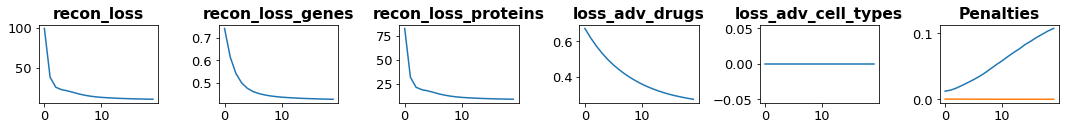

In [14]:
pretty_history.plot_losses(show=True)

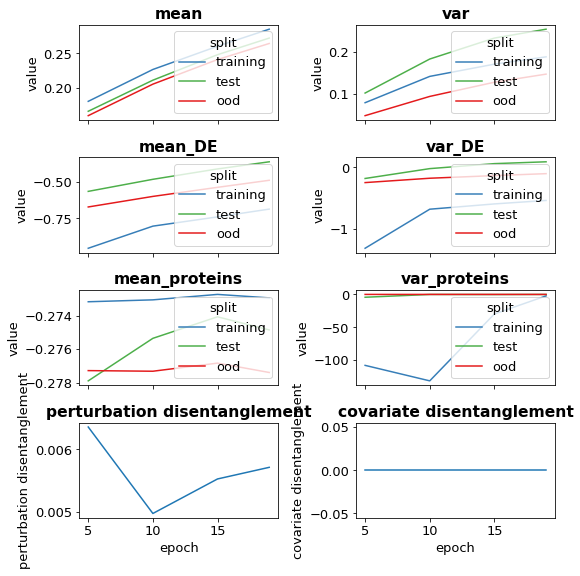

In [15]:
pretty_history.plot_metrics(epoch_min=0, show=True)

#### Plot perturbation embeddings

In [20]:
compert_api = ComPertAPI(datasets, autoencoder)

In [21]:
perts_anndata = compert_api.get_drug_embeddings()
perts_anndata

AnnData object with n_obs × n_vars = 29 × 256
    obs: 'condition'

In [23]:
from MultiCPA.plotting import CompertVisuals
compert_plots = CompertVisuals(compert_api, fileprefix=None)

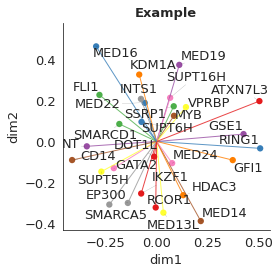

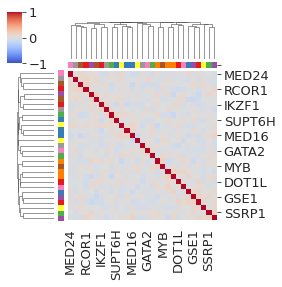

In [24]:
compert_plots.plot_latent_embeddings(compert_api.emb_perts, kind='perturbations', show_text=True)

Remark: The model for this demo is trained until 20 epoch